# Two Node Entanglement Distribution

In this file, we use SeQUeNCe to simulate entanglement distribution between two adjacent network nodes (using only the Barrett-Kok entanglement generation protocol). The network topology, including hardware components, is shown below:

<img src="./notebook_images/2_node_topo.png" width="500"/>

## Example

### Import

We must first import the necessary tools from SeQUeNCe to run our simulations.

- `Timeline` is the main simulation tool, providing an interface for the discrete-event simulation kernel.
- `QuantumRouter` provides a ready-to-use quantum router implementing SeQUeNCe's modular design. `BSMNode` provides a simpler, ready-to-use quantum node placed between routers as required by the entanglement generation protocol.
- `QuantumChannel` and `ClassicalChannel` are communication links between quantum nodes, providing models of optical fibers.
- The `Rule` class is used to direct the behavior of protocols within the simulation by providing explicit steps to be taken. Rules include a condition that must be met by a router and the action that should be performed when the condition is met.
- The `EntanglementGenerationA` is our implementation of the Barrett-Kok protocol and is used in defining rules for this simulation.

In [3]:
from ipywidgets import interact
from matplotlib import pyplot as plt
import time

In [4]:
from sequence.kernel.timeline import Timeline
from sequence.topology.node import QuantumRouter, BSMNode
from sequence.components.optical_channel import QuantumChannel, ClassicalChannel
from sequence.resource_management.rule_manager import Rule
from sequence.entanglement_management.generation import EntanglementGenerationA

### Defining Custom Behavior with Rules

This example demonstrates how to use rules within the Resource Management module to define network behavior. In SeQUeNCe, rules define a **condition** under which the rule is satisfied and an **action** that should be performed by a node's Resource Management module when the condition is met. More details are available in the documentation on rules, but we implement the basics here.

The rule condition we define simply requires a memory to be in the `RAW` state, that is, not occupied by a protocol or entangled with another memory.

The rule action differs between the two router nodes in the network. On the first node, a memory that meets our condition is given to an `EntanglementGenerationA` instance to begin entanglement. The action returns this protocol as well as a requirement of the other router -- that it also has an `EntanglementGenerationA` protocol to pair to. On the second router, the protocol is simply created and returned by the action.

In [5]:
# our rule condition requires RAW (unentangled) memories
def eg_rule_condition(memory_info, manager):
    if memory_info.state == "RAW":
        return [memory_info]
    else:
        return []

# define action to be taken when we meet our condition on router 1
def eg_rule_action1(memories_info):
    # define requirement of protocols on other node
    def eg_req_func(protocols):
        for protocol in protocols:
            if isinstance(protocol, EntanglementGenerationA):
                return protocol
            
    # create entanglement generation protocol with proper parameters
    memories = [info.memory for info in memories_info]
    memory = memories[0]
    protocol = EntanglementGenerationA(None, "EGA." + memory.name, "m1", "r2", memory)
    protocol.primary = True
    
    # return values for a rule are the protocol created, the destination node, and the destination codition
    return [protocol, ["r2"], [eg_req_func]]

# define action to be taken when we meet our condition on router 2
def eg_rule_action2(memories_info):
    memories = [info.memory for info in memories_info]
    memory = memories[0]
    protocol = EntanglementGenerationA(None, "EGA." + memory.name, "m1", "r1", memory)
    return [protocol, [None], [None]]

### Building the Simulation

We are now ready to build the simulation itself. This example follows the usual process to ensure that all tools function properly:

1. Create the timeline for the simulation
2. Create the simulated network topology (here this is done explicitly, but this may also be handled by functions of the `Topology` class under `sequence.topology.topology`)
    - This includes adjustment of default hardware parameters as necessary
3. Instantiate custom protocols and ensure all protocols are set up (paired) properly (if necessary)
4. Initialize and run the simulation
    - This includes installation of custom rules
5. Collect and display the desired metrics

For this example, the desired metric is the number of completed entanglements over time (the aggregate number of entangled memories). Several elements of SeQUeNCe, including the Resource Management module, automatically collect simple metrics such as entanglement time. For custom or more advanced metrics, custom code may need to be written and applied. See the documentation for a list of metrics provided by default for each simulation tool.

In [6]:
def test(sim_time, cc_delay, qc_atten, qc_dist):
    """
    sim_time: duration of simulation time (ms)
    cc_delay: delay on classical channels (ns)
    qc_atten: attenuation on quantum channels (db/m)
    qc_dist: distance of quantum channels (km)
    """
    cc_delay *= 1e6
    qc_dist *= 1e3
    # construct the simulation timeline; the constructor argument is the simulation time (in ps)
    tl = Timeline(sim_time * 1e9)
    tl.seed(0)
    
    # first, construct the quantum routers
    # (with arguments for the node name, timeline, and number of quantum memories)
    r1 = QuantumRouter("r1", tl)
    r2 = QuantumRouter("r2", tl)
    # next, construct the BSM nodes
    # (with arguments for the node name, timeline, and the names of connected routers)
    m1 = BSMNode("m1", tl, ["r1", "r2"])
    for node in [r1, r2]:
        # update coherence time parameter for node memories (measured in seconds)
        node.memory_array.update_memory_params("coherence_time", 0.3)
    
    # create all-to-all classical connections
    nodes = [r1, r2, m1]
    for node1 in nodes:
        for node2 in nodes:
            if node1 == node2:
                continue
            # construct a classical communication channel
            # (with arguments for the channel name, timeline, length (in m), and delay (in ps))
            cc = ClassicalChannel("_".join(["cc", node1.name, node2.name]), tl, 1e3, delay=cc_delay)
            cc.set_ends(node1, node2)
    
    # create linear quantum network between routers and middle node
    # for this, we create quantum channels
    # (with arguments for the channel name, timeline, attenuation (in dB/km), and distance (in m))
    qc1 = QuantumChannel("qc_r1_m1", tl, qc_atten, qc_dist)
    qc1.set_ends(r1, m1)
    qc2 = QuantumChannel("qc_r2_m1", tl, qc_atten, qc_dist)
    qc2.set_ends(r2, m1)
    
    # initialize our simulation kernel and instantiate the written rules
    tl.init()
    rule1 = Rule(10, eg_rule_action1, eg_rule_condition)
    r1.resource_manager.load(rule1)
    rule2 = Rule(10, eg_rule_action2, eg_rule_condition)
    r2.resource_manager.load(rule2)
    
    tick = time.time()
    tl.run()
    print("execution time %.2f sec" % (time.time() - tick))
    
    # display our collected metrics
    data = []
    for info in r1.resource_manager.memory_manager:
        if info.entangle_time > 0:
            data.append(info.entangle_time / 1e12)
    data.sort()
    plt.plot(data, range(1, len(data) + 1), marker="o")
    plt.xlabel("Simulation Time (s)")
    plt.ylabel("Aggregated Number of Entangled Memory")
    plt.show()

### Running the Simulation

All that is left is to run the simulation with user input.

Parameters:

    sim_time: duration of simulation time (ms)
    cc_delay: delay on classical channels (ns)
    qc_atten: attenuation on quantum channels (db/m)
    qc_dist: distance of quantum channels (km)
    
The maximum execution time is around 2 seconds.

execution time 1.61 sec


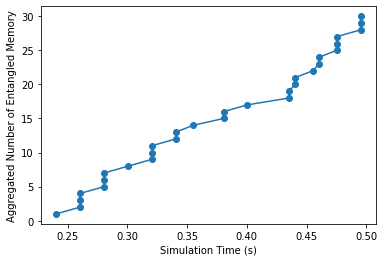

<function __main__.test(sim_time, cc_delay, qc_atten, qc_dist)>

In [7]:
interactive_plot = interact(test, sim_time=(100, 1000, 100), cc_delay=(100, 10000, 100), qc_atten=[1e-4, 2e-4, 3e-4], qc_dist=(1, 10, 1))
interactive_plot

### Results

In this example, we note that the number of entangled memories increases at a roughly linear rate with a slope inversely proportional to the quantum channel length and attenuation. We also see clusters of memories entangled at roughly the same time, based on entanglement processes that are started at the same time and encounter similar errors. The time intervals between these events roughly corresponds to the classical channel delay.